In [1]:
import numpy as np
import optuna
from sklearn import metrics
import warnings
import pickle
warnings.simplefilter(action='ignore', category=FutureWarning)
import joblib
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, r2_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

c:\Users\14390\.conda\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the data
data = np.load('DataSet/Classified_Data.npz')

Features = data['features']

Labels = data['labels']

print(Features.shape, Labels.shape)

(16871, 9) (16871,)


In [3]:
# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(Features, Labels, test_size=0.2, random_state=42)

# 创建 LightGBM 数据集
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)


In [4]:
# 设置 LightGBM 参数
params = {
    'objective': 'binary',  # 二分类问题
    'metric': 'binary_logloss',  # 评估指标为二分类对数损失
    'boosting_type': 'gbdt',  # 使用 GBDT 算法
    'num_leaves': 31,  # 叶子节点数
    'learning_rate': 0.01,  # 学习率
    'feature_fraction': 0.9,  # 特征的子抽样比例
    'bagging_fraction': 0.8,  # 数据的子抽样比例
    'bagging_freq': 5,  # bagging 的频率
    'verbose': 0,  # 信息输出设置成 0，不打印信息
    'is_unbalance': False  # 如果数据集不平衡，设置为 True
}

# 训练模型
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=5000,  # 迭代次数
    valid_sets=[test_data],  # 指定验证数据集
    # callbacks=[lgb.early_stopping(stopping_rounds=20)]  # 如果在10轮迭代内验证集的性能没有提升，提前停止训练
)

In [ ]:
import os
directory = "Classification/"
lgb_model_path  = os.path.join(directory, "lgb_model.txt")  # 使用 JSON 格式保存
gbm.save_model(lgb_model_path)

In [ ]:
# 评估模型
y_pred_prob = gbm.predict(X_train, num_iteration=gbm.best_iteration)  # 输出的是概率结果
y_pred = (y_pred_prob >= 0.5).astype(int)  # 将概率转换为二进制输出
print(classification_report(y_train, y_pred))
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7592
           1       1.00      1.00      1.00      5904

    accuracy                           1.00     13496
   macro avg       1.00      1.00      1.00     13496
weighted avg       1.00      1.00      1.00     13496

Accuracy: 0.9998518079430943


In [ ]:
X_test# 评估模型
y_pred_prob = gbm.predict(X_test, num_iteration=gbm.best_iteration)  # 输出的是概率结果
y_pred = (y_pred_prob >= 0.5).astype(int)  # 将概率转换为二进制输出
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1872
           1       0.87      0.91      0.89      1503

    accuracy                           0.90      3375
   macro avg       0.90      0.90      0.90      3375
weighted avg       0.90      0.90      0.90      3375

Accuracy: 0.9019259259259259


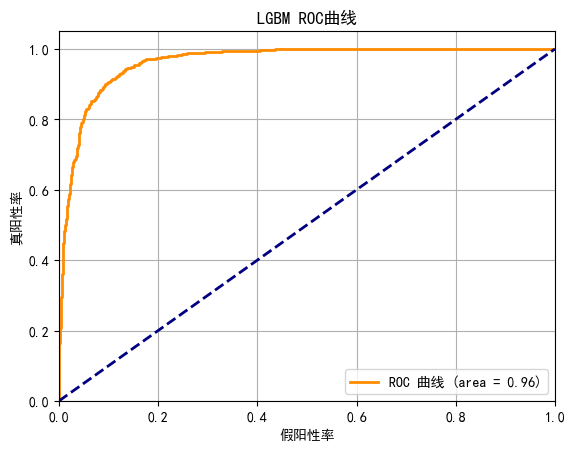

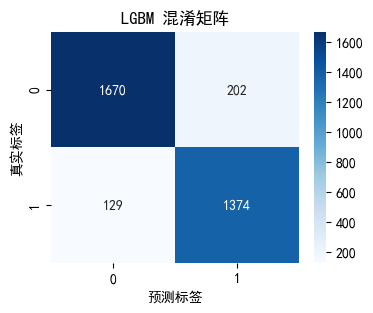

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
# 计算 ROC 曲线的 FPR（假阳性率）和 TPR（真阳性率）
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)  # 注意: y_pred_prob 需要是预测为正类的概率
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC 曲线 (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假阳性率')
plt.ylabel('真阳性率')
plt.title('XGBoost ROC曲线')
plt.legend(loc="lower right")
plt.grid()
plt.show()


# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 使用 Seaborn 绘图
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('LGBM 混淆矩阵')
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.show()

选择聚类

In [19]:
selected_features = Features[:, [0, 1, 6]]

In [20]:
sse = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(selected_features)
    sse.append(kmeans.inertia_)  # inertia_ 是 KMeans 拟合后的 SSE 值

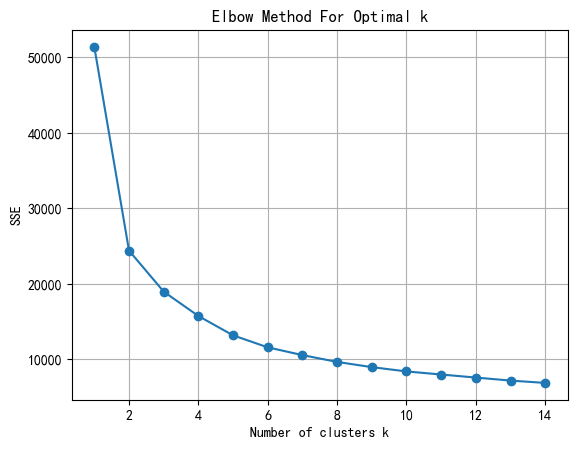

In [21]:
plt.plot(range(1, 15), sse, marker='o')
plt.xlabel('Number of clusters k')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

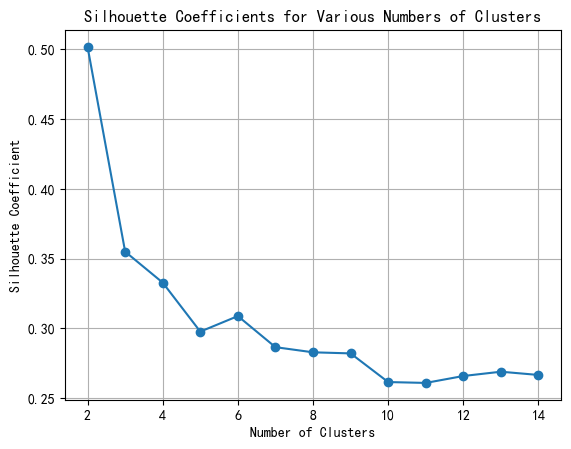

In [22]:
range_n_clusters = list(range(2, 15))  # 通常从 2 开始，因为一个簇的轮廓系数没有意义
silhouette_avg = []

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(selected_features)
    silhouette_avg.append(silhouette_score(selected_features, cluster_labels))

# 绘制轮廓系数与 k 值的图
plt.plot(range_n_clusters, silhouette_avg, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Coefficients for Various Numbers of Clusters')
plt.grid(True)
plt.show()

In [23]:
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(selected_features)

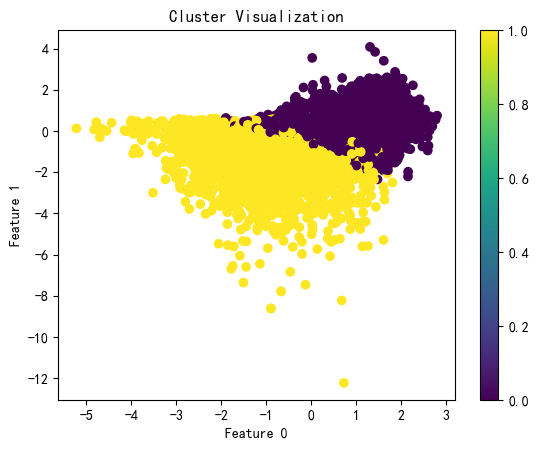

In [24]:
plt.scatter(selected_features[:, 0], selected_features[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.title('Cluster Visualization')
plt.colorbar()
plt.show()

In [25]:
# 数据集A: 类别0的点
dataset_A = Features[clusters == 0]
label_A = Labels[clusters == 0]
# 数据集B: 类别1的点
dataset_B = Features[clusters == 1]
label_B = Labels[clusters == 1]

In [26]:
# 计算标签的数量，以便平衡
count_A_0 = np.sum(label_A == 0)
count_A_1 = np.sum(label_A == 1)
min_count_A = min(count_A_0, count_A_1)

count_B_0 = np.sum(label_B == 0)
count_B_1 = np.sum(label_B == 1)
min_count_B = min(count_B_0, count_B_1)

# 提取平衡的数据集
dataset_A_balanced = np.concatenate((dataset_A[label_A == 0][:min_count_A], dataset_A[label_A == 1][:min_count_A]))
label_A_balanced = np.concatenate([np.zeros(min_count_A), np.ones(min_count_A)])

dataset_B_balanced = np.concatenate((dataset_B[label_B == 0][:min_count_B], dataset_B[label_B == 1][:min_count_B]))
label_B_balanced = np.concatenate([np.zeros(min_count_B), np.ones(min_count_B)])

# 定义测试数据集
dataset_C = np.concatenate((dataset_A[label_A == 0][min_count_A:], dataset_A[label_A == 1][min_count_A:], dataset_B[label_B == 0][min_count_B:], dataset_B[label_B == 1][min_count_B:]))
label_C = np.concatenate([np.zeros(len(dataset_A[label_A == 0][min_count_A:])), np.ones(len(dataset_A[label_A == 1][min_count_A:])), np.zeros(len(dataset_B[label_B == 0][min_count_B:])), np.ones(len(dataset_B[label_B == 1][min_count_B:]))])

# 重新赋值以匹配最终输出要求
dataset_A = dataset_A_balanced
label_A = label_A_balanced
dataset_B = dataset_B_balanced
label_B = label_B_balanced

# 确保数据正确无误
print("Dataset A shape: ", dataset_A.shape)
print("Label A: ", np.unique(label_A, return_counts=True))
print("Dataset B shape: ", dataset_B.shape)
print("Label B: ", np.unique(label_B, return_counts=True))
print("Dataset C shape: ", dataset_C.shape)
print("Label C: ", np.unique(label_C, return_counts=True))

Dataset A shape:  (8858, 9)
Label A:  (array([0., 1.]), array([4429, 4429], dtype=int64))
Dataset B shape:  (204, 9)
Label B:  (array([0., 1.]), array([102, 102], dtype=int64))
Dataset C shape:  (7809, 9)
Label C:  (array([0., 1.]), array([4933, 2876], dtype=int64))


In [31]:
Round = 3000

In [32]:
# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(dataset_A, label_A, test_size=0.2, random_state=42)

# 创建 LightGBM 数据集
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 设置 LightGBM 参数
params = {
    'objective': 'binary',  # 二分类问题
    'metric': 'binary_logloss',  # 评估指标为二分类对数损失
    'boosting_type': 'gbdt',  # 使用 GBDT 算法
    'num_leaves': 31,  # 叶子节点数
    'learning_rate': 0.01,  # 学习率
    'feature_fraction': 0.9,  # 特征的子抽样比例
    'bagging_fraction': 0.8,  # 数据的子抽样比例
    'bagging_freq': 5,  # bagging 的频率
    'verbose': 0,  # 信息输出设置成 0，不打印信息
    'is_unbalance': True  # 如果数据集不平衡，设置为 True
}

# 训练模型
gbm_B1 = lgb.train(params,
                train_data,
                num_boost_round=Round,  # 迭代次数
                valid_sets=[test_data],
                )  # 如果测试集上的表现在 10 轮迭代内没有改善，则提早停止训练


In [33]:
# 训练数据
y_pred_prob = gbm_B1.predict(X_train, num_iteration=gbm_B1.best_iteration)  # 输出的是概率结果
y_pred = (y_pred_prob >= 0.5).astype(int)  # 将概率转换为二进制输出
print(classification_report(y_train, y_pred))
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")

# 测试数据
y_pred_prob = gbm_B1.predict(X_test, num_iteration=gbm_B1.best_iteration)  # 输出的是概率结果
y_pred = (y_pred_prob >= 0.5).astype(int)  # 将概率转换为二进制输出
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3550
         1.0       1.00      1.00      1.00      3536

    accuracy                           1.00      7086
   macro avg       1.00      1.00      1.00      7086
weighted avg       1.00      1.00      1.00      7086

Accuracy: 0.9974597798475868
              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86       879
         1.0       0.85      0.88      0.87       893

    accuracy                           0.86      1772
   macro avg       0.86      0.86      0.86      1772
weighted avg       0.86      0.86      0.86      1772

Accuracy: 0.8628668171557562


In [147]:
# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(dataset_B, label_B, test_size=0.2, random_state=42)

# 创建 LightGBM 数据集
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 设置 LightGBM 参数
params = {
    'objective': 'binary',  # 二分类问题
    'metric': 'binary_logloss',  # 评估指标为二分类对数损失
    'boosting_type': 'gbdt',  # 使用 GBDT 算法
    'num_leaves': 31,  # 叶子节点数
    'learning_rate': 0.01,  # 学习率
    'feature_fraction': 0.9,  # 特征的子抽样比例
    'bagging_fraction': 0.8,  # 数据的子抽样比例
    'bagging_freq': 5,  # bagging 的频率
    'verbose': 0,  # 信息输出设置成 0，不打印信息
    'is_unbalance': True  # 如果数据集不平衡，设置为 True
}

# 训练模型
gbm_B1 = lgb.train(params,
                train_data,
                num_boost_round=Round,  # 迭代次数
                valid_sets=[test_data],
                )  # 如果测试集上的表现在 10 轮迭代内没有改善，则提早停止训练


In [148]:
# 训练数据
y_pred_prob = gbm_B1.predict(X_train, num_iteration=gbm_B1.best_iteration)  # 输出的是概率结果
y_pred = (y_pred_prob >= 0.5).astype(int)  # 将概率转换为二进制输出
print(classification_report(y_train, y_pred))
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")

# 测试数据
y_pred_prob = gbm_B1.predict(X_test, num_iteration=gbm_B1.best_iteration)  # 输出的是概率结果
y_pred = (y_pred_prob >= 0.5).astype(int)  # 将概率转换为二进制输出
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

              precision    recall  f1-score   support

         0.0       0.86      0.81      0.83     10771
         1.0       0.82      0.87      0.84     10808

    accuracy                           0.84     21579
   macro avg       0.84      0.84      0.84     21579
weighted avg       0.84      0.84      0.84     21579

Accuracy: 0.8378979563464479
              precision    recall  f1-score   support

         0.0       0.66      0.60      0.63      2716
         1.0       0.63      0.68      0.65      2679

    accuracy                           0.64      5395
   macro avg       0.64      0.64      0.64      5395
weighted avg       0.64      0.64      0.64      5395

Accuracy: 0.6396663577386469


分类效果不佳，使用聚类划分数据

DBSCAN聚类

In [5]:
data = np.load('./Data/all.npz')
Features_Check = data['x']
Labels_Check = data['y']

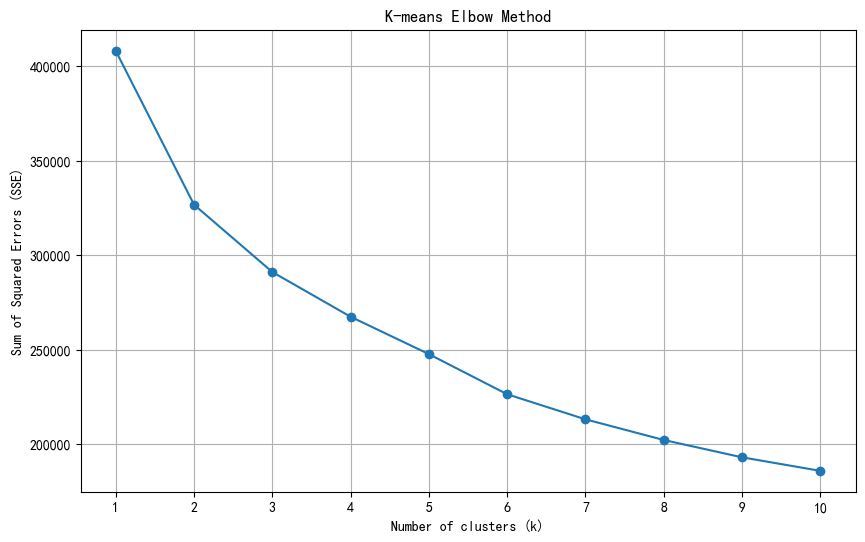

In [56]:
sse = []
k_range = range(1, 11)  # 一般从1到10试验不同的k值
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(Features)
    sse.append(kmeans.inertia_)  # inertia_ 是模型的SSE

### 4. 绘制SSE图像

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.title('K-means Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [53]:
# kmeans_final = KMeans(n_clusters=4, random_state=42)
# kmeans_final.fit(Features)
# clusters = kmeans_final.labels_

# # 可以使用clusters进行进一步的分析或者作为特征

In [33]:
dbscan = DBSCAN(eps=0.5, min_samples=4) 
clusters = dbscan.fit_predict(Features)

In [34]:
# 创建一个空字典来存储聚类结果
clustered_data = {}

# 遍历所有的聚类标签，包括噪声（标签为-1）
unique_labels = np.unique(clusters)
for label in unique_labels:
    # 从原始数据集中选择属于当前聚类标签的数据点
    clustered_data[label] = Features[clusters == label]

In [57]:
# 数据集A: 噪声点
# dataset_A = Features[clusters == -1]
# label_A = Labels[clusters == -1]
# # 数据集B: 类别0的点
# dataset_B = Features[clusters == 0]
# label_B = Labels[clusters == 0]
# # 数据集C: 所有其他类别的点
# dataset_C = Features[clusters > 0]
# label_C = Labels[clusters > 0]


# 数据集A: 类别0的点
dataset_A = Features[clusters == 0]
label_A = Labels[clusters == 0]
# 数据集B: 类别1的点
dataset_B = Features[clusters == 1]
label_B = Labels[clusters == 1]
# # 数据集A: 类别0的点
# dataset_C = Features[clusters == 2]
# label_C = Labels[clusters == 2]
# # 数据集B: 类别1的点
# dataset_D = Features[clusters == 3]
# label_D = Labels[clusters == 3]

验证原始数据集上的情况

In [36]:

# 数据集B: 类别0的点
# 数据集B: 类别0的点
# label_A_Check = Labels_Check[clusters == 0]
# # 数据集C：其他点
# label_D_Check = Labels_Check[clusters > 2]
# label_B_Check = Labels_Check[clusters == 1]
# # 数据集C：其他点
# label_C_Check = Labels_Check[clusters == 2]

# label_A_Check = Labels_Check[clusters == -1]
label_B_Check = Labels_Check[clusters == 0]
label_C_Check = Labels_Check[clusters >= 1]


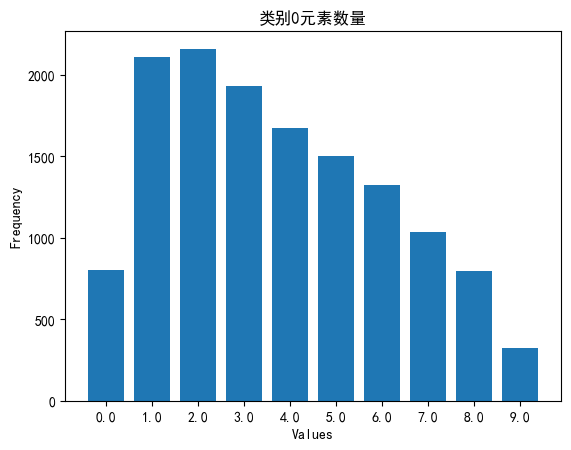

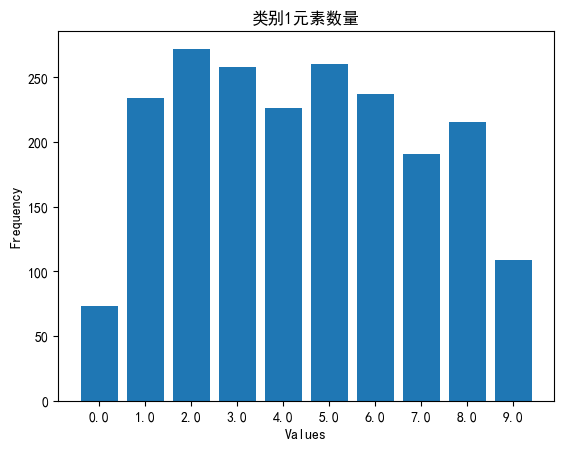

In [58]:
# 计算每个值的出现次数
# values, counts = np.unique(label_A_Check, return_counts=True)
# plt.bar(values, counts, tick_label=values)
# plt.xlabel('Values')
# plt.ylabel('Frequency')
# plt.title('噪声类元素数量')
# plt.xticks(values)
# plt.show()

plt.figure()
values, counts = np.unique(label_B_Check, return_counts=True)
plt.bar(values, counts, tick_label=values)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('类别0元素数量')
plt.xticks(values)
plt.show()

plt.figure()
values, counts = np.unique(label_C_Check, return_counts=True)
plt.bar(values, counts, tick_label=values)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('类别1元素数量')
plt.xticks(values)
plt.show()

# plt.figure()
# values, counts = np.unique(label_D_Check, return_counts=True)
# plt.bar(values, counts, tick_label=values)
# plt.xlabel('Values')
# plt.ylabel('Frequency')
# plt.title('类别1元素数量')
# plt.xticks(values)
# plt.show()

层次聚类

In [59]:
# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(dataset_A, label_A, test_size=0.2, random_state=42)

# 创建 LightGBM 数据集
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [60]:
# 设置 LightGBM 参数
params = {
    'objective': 'binary',  # 二分类问题
    'metric': 'binary_logloss',  # 评估指标为二分类对数损失
    'boosting_type': 'gbdt',  # 使用 GBDT 算法
    'num_leaves': 31,  # 叶子节点数
    'learning_rate': 0.01,  # 学习率
    'feature_fraction': 0.9,  # 特征的子抽样比例
    'bagging_fraction': 0.8,  # 数据的子抽样比例
    'bagging_freq': 5,  # bagging 的频率
    'verbose': 0,  # 信息输出设置成 0，不打印信息
    'is_unbalance': True  # 如果数据集不平衡，设置为 True
}

# 训练模型
gbm_B1 = lgb.train(params,
                train_data,
                num_boost_round=50000,  # 迭代次数
                valid_sets=[test_data],
                )  # 如果测试集上的表现在 10 轮迭代内没有改善，则提早停止训练


In [61]:
# 评估模型
y_pred_prob = gbm_B1.predict(X_train, num_iteration=gbm_B1.best_iteration)  # 输出的是概率结果
y_pred = (y_pred_prob >= 0.5).astype(int)  # 将概率转换为二进制输出
print(classification_report(y_train, y_pred))
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")

# 评估模型
y_pred_prob = gbm_B1.predict(X_test, num_iteration=gbm_B1.best_iteration)  # 输出的是概率结果
y_pred = (y_pred_prob >= 0.5).astype(int)  # 将概率转换为二进制输出
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3997
           1       1.00      1.00      1.00      6934

    accuracy                           1.00     10931
   macro avg       1.00      1.00      1.00     10931
weighted avg       1.00      1.00      1.00     10931

Accuracy: 0.9997255511847041
